<a href="https://colab.research.google.com/github/hany606/LCT_Spring20IU/blob/master/Lab10_IU_Hany_Hamed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tasks
* Simulate Spring Damper system without noise
* Plot that simulation & the measurement (based that we only can measure the position not the velocity)
* Simulate the previouse system with a random noise in the measurement
* Make a controller

In our case we will not be able to use FFT directly as we will control the signal directly, and will not wait till get the signal the using FFT and then filter and so on. So, FFT is not applicable as far as I know.

There is the following idea to use Kalman Filter as following: https://stackoverflow.com/questions/43377626/how-to-use-kalman-filter-in-python-for-location-data

But in my opinion it is maybe overkilling the exercise regarding it was a lab exercise. So, the proposed algorithm for the filtering is based on the idea of CNN to move along some of the measurements and take the weighted sum of them, this method will be as smoothing for the current reading and we will not control the rest.


The noise affects the measurements that affects the controller.

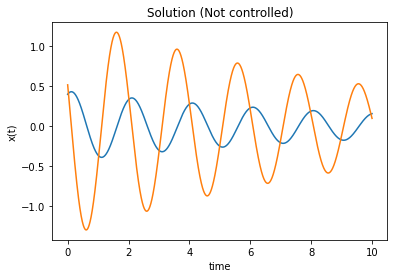

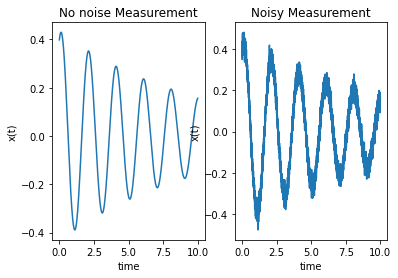

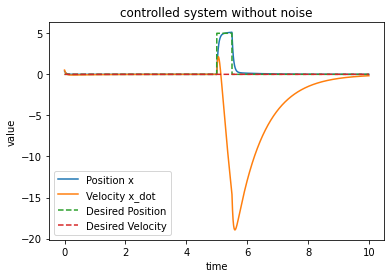

In [0]:
from scipy import signal
import matplotlib.pyplot as plt
from math import sin, cos
import numpy as np
from scipy import signal
from scipy.integrate import odeint

mu = 0.1
k = 5 # Damping
m = 0.5
A = np.array([[0,1],[-k/m,-mu/m]])
B = np.array([1/m,0]) # Control only the position
# C = np.array([[1,0],[0,0]])
C = np.array([[1,0]])
noise_mu, noise_stdev = 0,0.5
# u = 0
band_thresh = [-0.025,0.025]   # Here I make it high values which means that the filter is not used properly for filteration for now

kp = 10
kd = 0.6

# x_desired: x*, dx*
x_desired_vals = [5,0]

def x_desired(t):
  # return 5*sin(t)
  return x_desired_vals[0] if (t > 5 and t < 5.5) else 0    # Step function
  # return x_desired_vals[0]

def x_desired_dot(t):
  # return 2*cos(t)
  return x_desired_vals[1] if (t > 5 and t < 5.5) else 0  # Step function
  # return x_desired_vals[1]
  

# Spring mass damper
def SMD_sys(x,t):
  return A.dot(x)

def noise(noise_coeff=0.05):
  return noise_coeff*np.random.normal(noise_mu, noise_stdev)

def measurement_wo_noise(x):
  return C.dot(x)

def measurement(x):
  return C.dot(x) + C.dot(np.array([noise(), noise()]))

def measurement_filter(y):
  return y


def control_sys_wo_noise(x,t):
  dx = SMD_sys(x,t)
  y = measurement_wo_noise(x)
  y_filtered = measurement_filter(y)
  error     = x_desired(t) - y[0]
  error_dot = x_desired_dot(t) - dx
  # u = kp*error + kd*error_dot
  # u = -kp*error
  u = +kp*error + kd*error_dot
  # print(B.dot(u))
  return A.dot(x) + B.dot(u)

time = np.linspace(0, 10, 5000)
x0 = np.random.rand(2)            # initial state

solution = odeint(SMD_sys, x0, time)

solution_measurement = [measurement_wo_noise(i) for i in solution]
solution_measurement_noisy = [measurement(i) for i in solution]



plt.plot(time, solution)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('Solution (Not controlled)')
plt.show()

plt.subplot(121)
plt.plot(time, solution_measurement)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('No noise Measurement')

plt.subplot(122)
plt.plot(time, solution_measurement_noisy)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('Noisy Measurement')
plt.show()


# -------------------------Filtering--------------------------------------
sp_noisy = np.fft.fft(solution_measurement_noisy)


def BandPassFilter(signal, threshold):
  new_signal = signal.copy()
  for i,val in enumerate(signal):
    if(val.real < threshold[0]):
        new_signal[i] = (threshold[0]+val.imag)
    if(val.real > threshold[1]):
        new_signal[i] = (threshold[1]+val.imag)
  return new_signal

def SmoothFilter(signal,set=50):
  new_signal = signal.copy()
  for i,val in enumerate(signal):
    summation = val
    counter = 1
    for x in range(1,set):
      if(i+x >= len(signal)):
        break
      summation += signal[i+x].imag
      counter += 1
    new_signal[i] = summation/counter
  return new_signal

def MinFilter(signal, set=5):
  new_signal = signal.copy()
  for i,val in enumerate(signal):
    mn = val
    for x in range(1,set):
      if(i+x >= len(signal)):
        break
      mn = min(signal[i+x].imag, mn)
    new_signal[i] = mn
  return new_signal



# sp_filtered = SmoothFilter(sp_noisy)
# sp_filtered = SmoothFilter(sp_filtered)
# sp_filtered = BandPassFilter(sp_noisy, band_thresh)
# sp_filtered = SmoothFilter(sp_noisy)

# sp_filtered = MinFilter(sp_noisy)
# filtered_measurement = np.fft.ifft(sp_filtered)

freq = np.fft.fftfreq(time.shape[-1])

# -----------------------------Plotting filteration-------------------------------------------

# plt.subplot(121)
# plt.plot(freq, sp_noisy.real, freq, sp_noisy.imag)
# plt.title("FFT to noisy measurement")
# plt.show()
# plt.subplot(122)
# plt.plot(freq, sp_filtered.real, freq, sp_filtered.imag)
# plt.title("FFT to filtered signal")
# plt.show()

# plt.subplot(121)
# plt.plot(time, solution_measurement_noisy, "b")
# plt.xlabel('time')
# plt.ylabel('value')
# plt.title('Noisy signal')
# plt.subplot(122)
# plt.plot(time, filtered_measurement, "b")
# plt.xlabel('time')
# plt.ylabel('value')
# plt.title('Filtered signal')

# plt.show()
# ------------------------------------------------------------------------

# controlled_solution = odeint(control_sys, x0, time)


# plt.plot(time, controlled_solution)
# plt.xlabel('time')
# plt.ylabel('value')
# plt.title('controlled system with noise')
# plt.show()

controlled_solution_wo_noise = odeint(control_sys_wo_noise, x0, time)
x_desired_plt = []
for i in time:
  x_desired_plt.append([x_desired(i),x_desired_dot(i)])

plt.plot(time, controlled_solution_wo_noise)
plt.plot(time, x_desired_plt, linestyle='dashed')
plt.xlabel('time')
plt.ylabel('value')
plt.title('controlled system without noise')
plt.legend(labels=['Position x', 'Velocity x_dot', 'Desired Position', 'Desired Velocity'])
plt.show()


# Using Kalman Filter  (Not working properly)



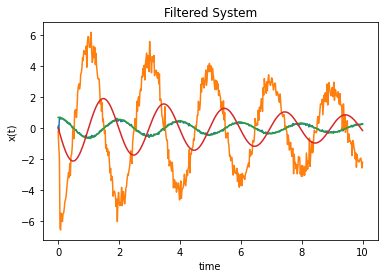

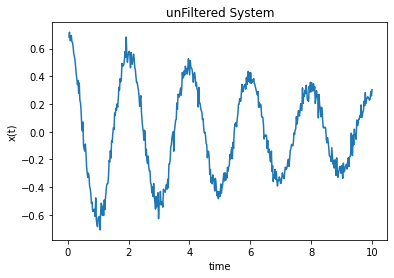

/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


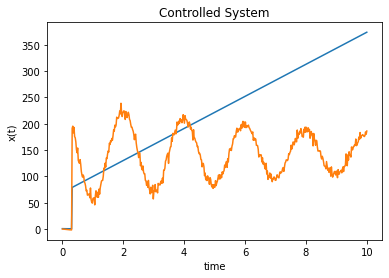

In [253]:
from scipy import signal
import matplotlib.pyplot as plt
from math import sin, cos
import numpy as np
from scipy import signal
from scipy.integrate import odeint

mu = 0.1
k = 5
m = 0.5
A = np.array([[0,1],[-k/m,-mu/m]])
B = np.array([0,1/m])
# C = np.array([[1,0],[0,0]])
C = np.array([[1,0]])
noise_mu, noise_stdev = 0,0.5
# u = 0
band_thresh = [-0.025,0.025]   # Here I make it high values which means that the filter is not used properly for filteration for now

kp = 100
kd = 0

# x_desired: x*, dx*
x_desired_vals = [5,0]

def x_desired(t):
  # return 5*sin(t)
  # return x_desired_vals[0] if t > 5 else 0    # Step function
  return x_desired_vals[0]

def x_desired_dot(t):
  # return 10*cos(t)
  # return x_desired_vals[1] if t > 5 else 0  # Step function
  return x_desired_vals[1]
  

# Spring mass damper
def SMD_sys(x,t):
  return A.dot(x)

def noise(noise_coeff=0.08):
  return noise_coeff*np.random.normal(noise_mu, noise_stdev)


def measurement(x):
  return C.dot(x) + C.dot(np.array([noise(), noise()]))

def measurement_filter(y):
  yy = ma.asarray(y)
  kf = KalmanFilter(transition_matrices = A, observation_matrices = C)
  yy[1] = ma.masked   # measurement at timestep 1 is unobserved
  kf = kf.em(yy, n_iter=10)
  (filtered_state_means, filtered_state_covariances) = kf.filter(yy)

  return filtered_state_means

time = np.linspace(0, 10, 500)

solution = odeint(SMD_sys, x0, time)
measurements = [measurement(i) for i in solution]

# print(measurements)

from pykalman import KalmanFilter
import numpy as np
kf = KalmanFilter(transition_matrices = A, observation_matrices = C)
from numpy import ma
measurements = ma.asarray(measurements)
measurements[1] = ma.masked   # measurement at timestep 1 is unobserved
kf = kf.em(measurements, n_iter=10)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)


plt.plot(time, filtered_state_means)
plt.plot(time, solution)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('Filtered System')
plt.show()

plt.plot(time, measurements)
# plt.plot(time, solution)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('unFiltered System')
plt.show()


counter = 0
thresh_counter = 10
local_filtering_list = []
local_target_list = []

def control_sys(x,t):
  global counter
  global thresh_counter
  global local_filtering_list
  global local_target_list

  # global u
  dx = SMD_sys(x,t)
  y = measurement(x)

  if(counter < thresh_counter):
    local_filtering_list.append(y)
    local_target_list.append([x_desired(t), x_desired_dot(t)])
    u = 0
  else:
    counter = 0
    new_y = measurement_filter(local_filtering_list)
    error     = local_target_list - new_y
    error = sum(error)
    u = -kp*error
    local_filtering_list = []
    local_target_list = []
  counter += 1

  return A.dot(x) + B.dot(u)

controlled_solution = odeint(control_sys, x0, time)

plt.plot(time, controlled_solution)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('Controlled System')
plt.show()


In [0]:
! pip install pykalman

# Control noisy observation with naiive approach




/usr/local/lib/python3.6/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


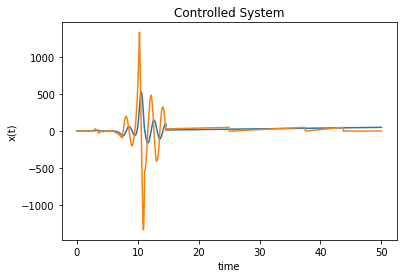

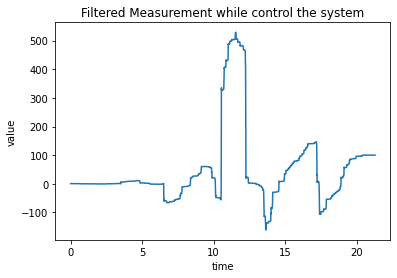

In [258]:
from scipy import signal
import matplotlib.pyplot as plt
from math import sin, cos
import numpy as np
from scipy import signal
from scipy.integrate import odeint

mu = 0.1
k = 5
m = 0.5
A = np.array([[0,1],[-k/m,-mu/m]])
B = np.array([0,1/m])
# C = np.array([[1,0],[0,0]])
C = np.array([[1,0]])
noise_mu, noise_stdev = 0,0.5
# u = 0
band_thresh = [-0.025,0.025]   # Here I make it high values which means that the filter is not used properly for filteration for now

kp = 100
kd = 0

# x_desired: x*, dx*
x_desired_vals = [5,0]

def x_desired(t):
  # return 5*sin(t)
  # return x_desired_vals[0] if t > 5 else 0    # Step function
  return x_desired_vals[0]

def x_desired_dot(t):
  # return 10*cos(t)
  # return x_desired_vals[1] if t > 5 else 0  # Step function
  return x_desired_vals[1]
  

# Spring mass damper
def SMD_sys(x,t):
  return A.dot(x)

def noise(noise_coeff=0.08):
  return noise_coeff*np.random.normal(noise_mu, noise_stdev)


def measurement(x):
  return C.dot(x) + C.dot(np.array([noise(), noise()]))

def measurement_filter(y):
  return y


counter = 0
thresh_counter = 7
weighted_sum_weights = [1/thresh_counter for i in range(thresh_counter)]
local_filtering_list = []


ms = []

def control_sys(x,t):
  global counter
  global thresh_counter
  global local_filtering_list
  # global u
  dx = SMD_sys(x,t)
  y = measurement(x)

  # u = kp*error + kd*error_dot
  # u = -kp*error
  if(counter < thresh_counter):
    # ms.append(y)
    u = 0
    # pass
  else:
    counter = 0
    new_y = 0
    for i in range(len(local_filtering_list)):
      new_y += local_filtering_list[i]*weighted_sum_weights[i]
    # new_y /= sum(local_filtering_list)    # For normalization
    local_filtering_list = []
    error     = x_desired(t) - new_y[0]
    # print(error, "as")
    error_dot = x_desired_dot(t) - dx
    u = -kp*error
    ms.append(new_y)
    # print(u)
  counter += 1
  local_filtering_list.append(y)
  # u = 0
  return A.dot(x) + B.dot(u)


time = np.linspace(0, 50, 10000)
x0 = np.random.rand(2)            # initial state


controlled_solution = odeint(control_sys, x0, time)

plt.plot(time, controlled_solution)
plt.xlabel('time')
plt.ylabel('x(t)')
plt.title('Controlled System')
plt.show()


# plt.plot(time, solution_measurement_noisy)
# plt.xlabel('time')
# plt.ylabel('x(t)')
# plt.title('Noisy Measurement')
# plt.show()

plt.plot(time[:min(len(ms),len(time))], ms[:min(len(ms),len(time))])
plt.xlabel('time')
plt.ylabel('value')
plt.title('Filtered Measurement while control the system')
plt.show()